In [20]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [86]:
plt.style.use("matplotlibrc")

In [22]:
def s(x):
    return np.tanh(x)

In [23]:
### Parameters
N_net = 500
N_in = 10

cf_net = 0.1
cf_in = 0.1

std_conn = 1.

var_act_target = 0.33**2

mu_gain = 0.0005

n_t = 200000

t_ext_off = 100000

# Driven Random Dynamic Reservoir with Homeostatic Variance Control

## Mathematical Description

### Dynamics
$$\begin{align}
x_i^{t+1} &= \mathrm{tanh}\left( g_i^t I_i^{t+1} \right) \\
I_i^{t+1} &= \sum_{j=1}^{N_{\rm net}} W_{ij} x_j^t + \sum_{k=1}^{N_{\rm in}} E_{ik} e_k^{t+1} \\
g_i^{t+1} &= \mu_{g} \left[ \mathrm{Var_{target}} - \left( x_i^t - \langle x_i \rangle \right)^2 \right]
\end{align}
$$
### Parameters / Settings

$W_{ij}$ is a sparse random matrix with connection probability ${\rm cf_{net}}$. Nonzero entries were drawn from a Gaussian distribution $\mathcal{N}(\mu = 0,\sigma = \sigma_{\rm conn} / \sqrt{N_{\rm net} {\rm cf_{net}}})$. Diagonal entries were always set to zero.

$E_{ij}$ is also a sparse random matrix with connection probability ${\rm cf_{in}}$. Nonzero entries were drawn from a Gaussian distribution $\mathcal{N}(\mu = 0,\sigma = \sigma_{\rm conn} / \sqrt{N_{\rm in} {\rm cf_{in}}})$.

$e_i^{t}$ are activities of an input layer of size $N_{\rm in}$, which are independently drawn from a uniform $\rm \left[0,1\right]$ distribution for each time step. External input is turned off after $t_{\rm ext.off}$.

By changing individual gain values $g_i$, the homeostatic control tries to drive the activity variance of every cell to the value given by $\mathrm{Var_{target}}$. However, this mechanism is also switched off after $t_{\rm ext.off}$. This is done because we can assume that homeostatic processes would biologically act on much slower timescales than changes in input. Before $t_{\rm ext.off}$, we can set $\mu_{g}$ to relatively high values to let homeostasis converge under external drive.

See all parameters in the following table.

| Parameter               | Value              |
| ----------------------- |--------------------|
| $N_{\rm net}$           | {{N_net}}          |
| $N_{\rm in}$            | {{N_in}}           |
| ${\rm cf_{net}}$        | {{cf_net}}         |
| ${\rm cf_{in}}$         | {{cf_in}}          |
| $\sigma_{\rm conn}$     | {{std_conn}}       |
| $\mu_{g}$               | {{mu_gain}}        |
| $\mathrm{Var_{target}}$ | {{var_act_target}} |
| $n_t$ (Sim. Steps)      | {{n_t}}            |
| $t_{\rm ext.off}$       | {{t_ext_off}}      |

In [24]:
### Recording
x_net_rec = np.ndarray((n_t, N_net))
x_in_rec = np.ndarray((n_t, N_in))

gain_rec = np.ndarray((n_t, N_net))

var_mean_rec = np.ndarray((n_t))

In [25]:
### State Variables

W = np.random.normal(0., std_conn, (N_net,N_net))
W *= (np.random.rand(N_net, N_net) <= cf_net) / ( N_net * cf_net )**.5
W[range(N_net), range(N_net)] = 0.

E = np.random.normal(0., std_conn, (N_net, N_in))
E *= (np.random.rand(N_net, N_in) <= cf_in) / ( N_in * cf_in )**.5

x_net = np.random.normal(0., 1., (N_net))
x_in = np.zeros((N_in))

gain = np.ones((N_net))

In [110]:
### Main Loop
for t in tqdm(range(n_t)):
    
    if t < t_ext_off:
        x_in = np.random.rand(N_in)
    else:
        x_in = np.zeros((N_in))
    
    I = gain * ( np.dot(W, x_net) + np.dot(E, x_in) )
    
    if t < t_ext_off:
        gain += mu_gain * ( var_act_target - x_net**2 )

    x_net = s(I)

    x_net_rec[t,:] = x_net
    x_in_rec[t,:] = x_in
    gain_rec[t,:] = gain
    var_mean_rec[t] = (x_net**2).mean()

100%|██████████| 200000/200000 [00:18<00:00, 10840.10it/s]


In [83]:
### Plotting

t_ax = np.array(range(n_t-100,n_t))

textwidth = 5.5532
std_figsize = (textwidth/2.,2.)
dpi_screen = 120

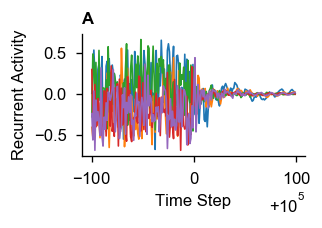

In [111]:
fig_act_trans, ax_act_trans = plt.subplots(figsize=std_figsize,dpi=dpi_screen)

t_pm = 100

t_ax_trans = np.array(range(t_ext_off - t_pm, t_ext_off + t_pm))



ax_act_trans.plot(t_ax_trans,x_net_rec[t_ext_off - t_pm:t_ext_off + t_pm,:5])
ax_act_trans.set_xlabel("Time Step")
ax_act_trans.ticklabel_format(axis='x', style='sci', useOffset=t_ext_off, useMathText=True)
ax_act_trans.set_ylabel("Recurrent Activity")

ax_act_trans.set_title("A",{'fontweight' : 'bold'}, loc="left")

fig_act_trans.tight_layout()
fig_act_trans.savefig("../plots/act_trans.png", dpi=300)

'''
ax_act_trans.set_title("Sample of Population Activity within $\\left[ t_{\\rm ext.off} - " + 
                       str(t_pm) + ", t_{\\rm ext.off} + " + 
                       str(t_pm) + " \\right]$")
'''


plt.show()

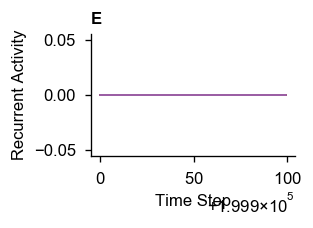

In [105]:
fig_act, ax_act = plt.subplots(figsize=std_figsize,dpi=dpi_screen)

ax_act.plot(t_ax,x_net_rec[-100:,:5])
ax_act.set_xlabel("Time Step")
ax_act.ticklabel_format(axis='x', style='sci', useOffset=n_t-100, useMathText=True)
ax_act.set_ylabel("Recurrent Activity")

ax_act.set_title("E",{'fontweight' : 'bold'}, loc="left")

fig_act.tight_layout()
fig_act.savefig("../plots/act.png", dpi=300)
'''
ax_act.set_title("Sample of Population Activity for the last 100 Steps")
'''
plt.show()

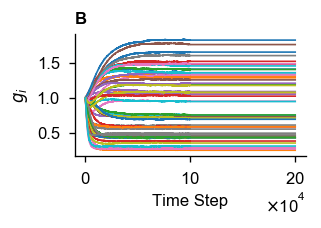

In [106]:
fig_gain, ax_gain = plt.subplots(figsize=std_figsize,dpi=dpi_screen)

ax_gain.plot(gain_rec[:,::10])
ax_gain.set_xlabel("Time Step")
ax_gain.ticklabel_format(axis='x', style='sci', scilimits=(4,4), useMathText=True)
ax_gain.set_ylabel("$g_i$")

ax_gain.set_title("B",{'fontweight' : 'bold'}, loc="left")

fig_gain.tight_layout()
fig_gain.savefig("../plots/gain.png", dpi=300)

'''
ax_gain.set_title("Gain Dynamics of $N_{\\rm net}/10$ Exemplary Neurons")
'''
plt.show()

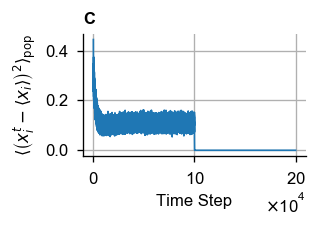

In [107]:
fig_var, ax_var = plt.subplots(figsize=std_figsize, dpi=dpi_screen)

ax_var.plot(var_mean_rec)
ax_var.set_xlabel("Time Step")
ax_var.ticklabel_format(axis='x', style='sci', scilimits=(4,4), useMathText=True)
ax_var.set_ylabel("$\\langle \\left( x_i^t - \\langle x_i \\rangle \\right)^2\\rangle_{\\rm pop}$")

ax_var.grid()

ax_var.set_title("C",{'fontweight' : 'bold'}, loc="left")

fig_var.tight_layout()
fig_var.savefig("../plots/var.png", dpi=300)

#ax_var.set_title("Population Mean of Squared Activity")

plt.show()

In [71]:
dt_subsample = 1000

l_abs_max = np.ndarray((int(n_t/dt_subsample)))

for k in tqdm(range(int(n_t/dt_subsample))):
    l_abs_max[k] = np.abs(np.linalg.eigvals((W.T*gain_rec[k*dt_subsample,:]).T).real).max()

100%|██████████| 200/200 [00:28<00:00,  6.49it/s]


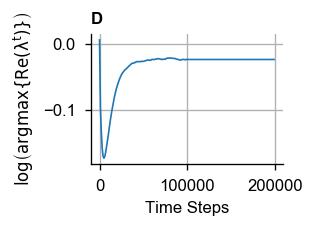

In [108]:
fig_eig, ax_eig = plt.subplots(figsize=std_figsize, dpi=dpi_screen)

t_ax_eig = np.array(range(int(n_t/dt_subsample)))*dt_subsample

ax_eig.plot(t_ax_eig, np.log(l_abs_max))

ax_eig.set_xlabel("Time Steps")
ax_eig.set_ylabel("${\\rm log \\left(argmax\\{Re(\\lambda^t)\\}\\right) }$")

ax_eig.grid()

ax_eig.set_title("D",{'fontweight' : 'bold'}, loc="left")

fig_eig.tight_layout()
fig_eig.savefig("../plots/eig.png", dpi=300)

#ax_eig.set_title("Log. of Largest Real Part of Eig.values of $g_i^t W_{ij} $")

plt.show()

In [114]:
from PIL import Image

comp_size = (int(textwidth*300),int(4.*300.))

im_comp = Image.new('RGBA', comp_size, color=(255,255,255,255))

images = [Image.open("../plots/act_trans.png"),
        Image.open("../plots/gain.png"),
        Image.open("../plots/var.png"),
        Image.open("../plots/eig.png"),
        Image.open("../plots/act.png")]

images_scaled = []

scaled_img_width = int(comp_size[0]/2)

for img in images:
    
    img_new_size =  (scaled_img_width,int(img.size[1]*scaled_img_width/img.size[0]))
    images_scaled.append(img.resize(img_new_size,resample=Image.BICUBIC))
    
for k in range(2):
    for l in range(2):
        box = [0,0,0,0]
        box[0] = int(l*comp_size[0]/2)
        box[1] = int(k*images_scaled[2*k+l].size[1])
        box[2] = box[0] + int(comp_size[0]/2)
        box[3] = box[1] + int(images_scaled[2*k+l].size[1])
        
        im_comp.paste(images_scaled[2*k+l],box)

im_comp.save("../plots/im_comp.png")

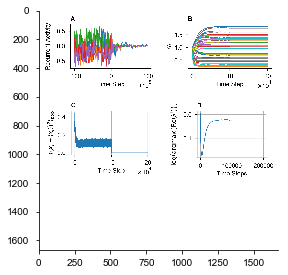

In [113]:
plt.imshow(im_comp)
plt.show()

In [80]:
std_figsize

(2.766, 2.0)

In [93]:
from PIL import ImageDraw

In [94]:
ImageDraw.ImageDraw.getfont()

TypeError: getfont() missing 1 required positional argument: 'self'